 # **Function Approximation Acrobot**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# install gym system dependencies
!pip install swig
!apt-get install -y xvfb x11-utils
!pip install PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            gym[box2d]==0.17.* 
! pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+5).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gym

## Tile Coding

Uses http://incompleteideas.net/tiles/tiles3.html

In [4]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')
import tiles3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def tiling_metrics(IHT):
    """ report index hash table state """
    print('IHT count:', IHT.count())
    print('IHT full:', IHT.fullp())
    if IHT.fullp():
        print('Overfull:', IHT.overfullCount)
    print('IHT size:', IHT.size)

In [6]:
class SarsaTileCodingFunctionApproximation():
    def __init__(self, state_bounds, actions, alpha, tilings, maxima, value=0):
        """
        state_bounds:  state space boundaries
        actions:  array of all the actions
        alpha:  each step learning rate
        tilings:  layers of tiles
        maxima:  largest value for scaling
        value:  initial weight value (0)
        """
        self.alpha = alpha
        self.num_tilings = tilings
        self.num_dimensions = len(state_bounds)
        dynamic_scaler = lambda x: max(int(maxima / (x[1] - x[0])), 1)
        self.scales = np.array(list(map(dynamic_scaler, state_bounds)))
        total_tiles = (tilings + 1)**self.num_dimensions * len(actions)
        self.weights = np.zeros(total_tiles) + value
        self.IHT = tiles3.IHT(total_tiles)

    def mytiles(self, state, action):
        # scale state for consistent tile mapping
        assert len(state) == self.num_dimensions
        scaled_state = np.multiply(self.scales, state)
        return tiles3.tiles(self.IHT, self.num_tilings, scaled_state, [action])

    def test(self, state, action):
        # select the correct weights and sum them
        active_tiles = self.mytiles(state, action)
        return np.sum(self.weights[active_tiles])

    def learn(self, state, action, target):
        # update active states by semi-gradient
        active_tiles = self.mytiles(state, action)
        previous = np.sum(self.weights[active_tiles])
        delta = self.alpha * (target - previous)           
        self.weights[active_tiles] += delta

In [7]:
# Acrobot state boundaries
state_bounds = np.array([(-1.0, +1.0),   # cosΘ1
                         (-1.0, +1.0),   # sinΘ1
                         (-1.0, +1.0),   # cosΘ2
                         (-1.0, +1.0),   # sinΘ2
                         (-4.0 * np.pi, +4.0 * np.pi),   # avΘ1
                         (-9.0 * np.pi, +9.0 * np.pi)])   # avΘ2

# Acrobot actions
actions = np.array([-1, 0, 1])   # negative, none, positive torque

## Semi-Gradient *Sarsa*(0)

In [8]:
def semi_gradient_sarsa_zero(env, actions, steps, episodes, gamma, epsilon, q_hat):
    """
    Input:
    env:  acrobot, gym environment
    episodes:  max episodes to run
    steps:  max steps for this environment
    gamma:  discount factor [0..1]
    epsilon:  epsilon-greedy parameter
    q_hat:  function approximation
    Output:  list of maximum delta for each episode
    """
    def policy(state, q_hat, epsilon):
        if np.random.rand() > epsilon:
            q_values = [q_hat.test(state, action) for action in actions]
            return np.argmax(q_values)
        else:
            return np.random.choice(actions)

    deltas = []
    for episode in range(episodes):
        total_reward = 0
        if episode % 10 == 0:
            print('Episode', episode, 'of', episodes)

        S = env.reset()
        A = policy(S, q_hat, epsilon)
        for step in range(steps):
            S_, R, done, _ = env.step(A)
            total_reward += R  # accumulate and divide by steps, for plots

            if done:  # S_ is terminal
                q_hat.learn(S, A, R)
                if step+1 != steps:
                    print('Successful episode', episode, 'reward:', total_reward)
                break

            A_ = policy(S_, q_hat, epsilon)
            q_hat.learn(S, A, R + gamma * q_hat.test(S_, A_))
            S, A = S_, A_
  
        deltas.append(total_reward)

        if not done and episode % 10 == 0:
            print('Episode', episode+1, 'of', episodes, 'reward:', total_reward)

    return deltas

In [9]:
q_hat = SarsaTileCodingFunctionApproximation(state_bounds, actions, alpha=0.1, tilings=8, maxima=32)

env = gym.make('Acrobot-v1')
# Acrobot environment enforces a maximum step count (500)
deltas = semi_gradient_sarsa_zero(env, actions, steps=500, episodes=100, gamma=0.9, epsilon=0.4, q_hat=q_hat)

Episode 0 of 100
Successful episode 0 reward: -468.0
Episode 10 of 100
Episode 20 of 100
Successful episode 24 reward: -431.0
Successful episode 29 reward: -422.0
Episode 30 of 100
Successful episode 31 reward: -335.0
Successful episode 33 reward: -475.0
Episode 40 of 100
Successful episode 45 reward: -388.0
Successful episode 46 reward: -456.0
Successful episode 49 reward: -407.0
Episode 50 of 100
Successful episode 54 reward: -497.0
Episode 60 of 100
Successful episode 61 reward: -371.0
Successful episode 68 reward: -446.0
Successful episode 69 reward: -277.0
Episode 70 of 100
Episode 80 of 100
Successful episode 89 reward: -497.0
Episode 90 of 100
Successful episode 94 reward: -438.0
Successful episode 96 reward: -464.0
Successful episode 97 reward: -403.0


In [10]:
# report state of the index hash table
tiling_metrics(q_hat.IHT)

IHT count: 516554
IHT full: False
IHT size: 1594323


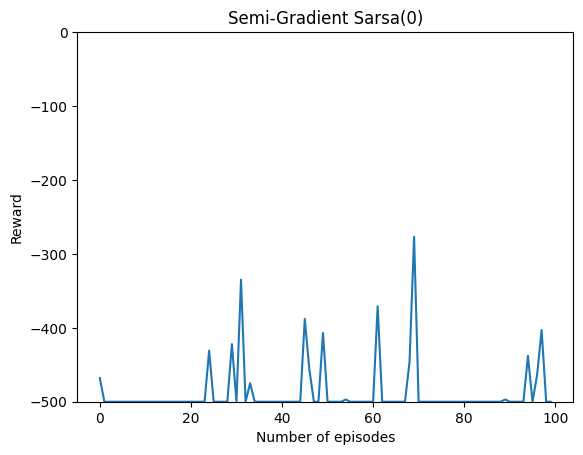

In [11]:
plt.plot(deltas)
plt.ylim(-500,0) # rewards range over 500 steps
plt.xlabel('Number of episodes')
plt.ylabel('Reward')
plt.title('Semi-Gradient Sarsa(0)')
plt.show()

## Semi-Gradient TD(𝜆)

In [12]:
class TDTileCodingFunctionApproximation():
    def __init__(self, state_bounds, alpha, tilings, maxima, value=0):
        """
        Input:
            state_bounds:  state space boundaries
            alpha:  each step learning rate
            tilings:  layers of tiles
            maxima:  largest value for scaling
            value:  initial weight value (0)
        """
        self.alpha = alpha
        self.num_tilings = tilings
        self.num_dimensions = len(state_bounds)
        dynamic_scaler = lambda x: max(int(maxima / (x[1] - x[0])), 1)
        self.scales = np.array(list(map(dynamic_scaler, state_bounds)))
        self.total_tiles = (tilings + 1)**self.num_dimensions
        self.weights = np.zeros(self.total_tiles) + value
        self.trace = np.zeros(self.total_tiles)
        self.IHT = tiles3.IHT(self.total_tiles)

    def reset_trace(self):
        total_tiles = (self.num_tilings + 1)**self.num_dimensions
        self.trace = np.zeros(total_tiles)

    def trace_delta(self, active_tiles):
        activate = np.zeros(self.total_tiles)
        activate[active_tiles] = 1
        return activate

    def mytiles(self, state):
        # scale state for consistent tile mapping
        assert len(state) == self.num_dimensions
        scaled_state = np.multiply(self.scales, state)
        return tiles3.tiles(self.IHT, self.num_tilings, scaled_state)

    def update(self, from_state, to_state, reward, gamma, decay):
        # update trace and weight vectors for a policy iteration
        active_tiles = self.mytiles(from_state)
        active_value = np.sum(self.weights[active_tiles])
        update_tiles = self.mytiles(to_state)
        update_value = np.sum(self.weights[update_tiles])
        self.trace = gamma * decay * self.trace + self.trace_delta(active_tiles)
        delta = reward + gamma * update_value - active_value
        self.weights += self.alpha * delta * self.trace

In [13]:
def semi_gradient_td_lambda(env, steps, episodes, gamma, decay, epsilon, v_hat):
    """
    Input:
        env:  acrobot, gym environment
        episodes:  max episodes to run
        gamma:  discount factor [0..1]
        decay:  trace decay (lambda) parameter
        epsilon:  epsilon-greedy policy parameter
        v_hat:  function approximation (holds weights and traces)
    Output:
        list of maximum delta for each episode
    """
    def policy(st, epsilon):
        """
        A policy must be provided as input to the TD algorithm.
        So implement this simple acrobot policy for evaluation:
          If theta0 angular velocity is zero or positive, then
          apply positive torque; apply negative if negative.
          However, E% of the time take a random action instead.
        Recall acrobot has 3 actions:
           0: apply -1 torque to the actuated joint
           1: apply 0 torque to the actuated joint
           2: apply 1 torque to the actuated joint
        """
        assert len(st) == 6
        if np.random.rand() > epsilon:
            return np.random.choice(actions)
        if st[4] >= 0:  # theta0 angular velocity
            return actions[2]
        return actions[0]

    deltas = []
    for episode in range(episodes):
        total_reward = 0

        S = env.reset()
        v_hat.reset_trace()

        for step in range(steps):
            A = policy(S, epsilon)
            S_, R, done, _ = env.step(A)
            v_hat.update(S, S_, R, gamma, decay)
            S = S_

            total_reward += R  # accumulate and divide by steps, for plots
            if done:
                if step+1 != steps:
                    print('Successful episode', episode, 'reward:', total_reward)
                break

        average_reward = total_reward / (step+1)
        deltas.append(total_reward)
        if not done and episode % 10 == 0:
            print('Episode', episode+1, 'of', episodes, 'reward:', total_reward)

    return deltas

In [14]:
v_hat = TDTileCodingFunctionApproximation(state_bounds, alpha=0.01, tilings=8, maxima=32)

env = gym.make('Acrobot-v1')
# Acrobot environment enforces a maximum step count (500)
deltas = semi_gradient_td_lambda(env, steps=500, episodes=100, gamma=0.9, decay=0.1, epsilon=0.2, v_hat=v_hat)

Successful episode 1 reward: -452.0
Successful episode 3 reward: -475.0
Successful episode 5 reward: -389.0
Successful episode 7 reward: -334.0
Successful episode 8 reward: -354.0
Successful episode 9 reward: -475.0
Successful episode 10 reward: -457.0
Successful episode 11 reward: -361.0
Successful episode 14 reward: -453.0
Successful episode 16 reward: -317.0
Successful episode 20 reward: -351.0
Successful episode 21 reward: -455.0
Successful episode 22 reward: -323.0
Successful episode 26 reward: -376.0
Successful episode 27 reward: -348.0
Successful episode 29 reward: -369.0
Successful episode 33 reward: -356.0
Successful episode 36 reward: -454.0
Successful episode 38 reward: -368.0
Successful episode 41 reward: -285.0
Successful episode 42 reward: -347.0
Successful episode 45 reward: -442.0
Successful episode 47 reward: -417.0
Successful episode 50 reward: -479.0
Successful episode 52 reward: -484.0
Successful episode 53 reward: -454.0
Successful episode 58 reward: -409.0
Success

In [16]:
# report state of the index hash table
tiling_metrics(v_hat.IHT)

IHT count: 262757
IHT full: False
IHT size: 531441


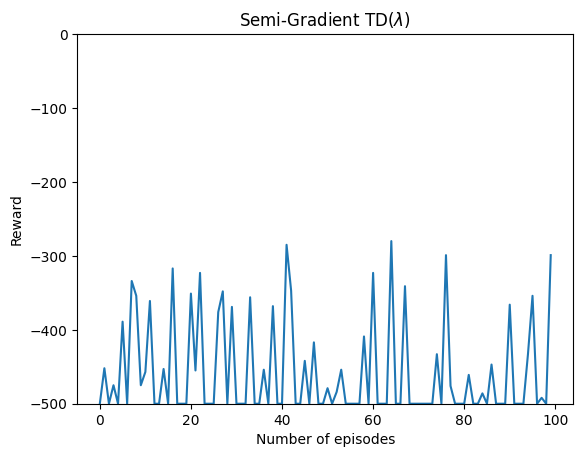

In [17]:
plt.plot(deltas)
plt.ylim(-500,0) # rewards range over 500 steps
plt.xlabel('Number of episodes')
plt.ylabel('Reward')
plt.title(r'Semi-Gradient TD($\lambda$)')
plt.show()